# Genetic Algorithms: Feature Selection & Hyperparameters

![](https://g-scop.grenoble-inp.fr/medias/photo/gscop-rub-oc_1425923414759-png)



## Introduction

This notebook aims to combine my love of genetic algorithms with the model building steps of feature selection and hyperparameter optimisation. I have previously used genetic algorithms to choose which features to include in a model and then as a secondary process conducted hyperparameter optimisation. This time I want to see if the two steps can be integrated.

This notebook has 2 primary objectives:
1. Serve as practice using Python as I am typically an R user
1. Apply Genetic Algorithms to combined feature selection and hyperparameter optimisation

I believe there are two main ways to achieve the optimisation of feature selection and hyperparameters:

1. Nested: For a candidate solution, firstly choose which features to include and then optimise hyperparameters
1. Simualtaneous: For a candidate solution choose both feature subsets and hyperparameters at the same time

This notebook explores the first case, the reason for this is it is thought that nesting will provide a greater range of hyperparameter values for each model. As a result this likely means that this approach will take longer than the simualtaneous approach.

The 'Santander Customer Satisfaction' dataset will be used within this notebook as it high dimensional (300+ predictors), providing a good opportunity to test the optimisation process (especially the third objective). 

The notebook has been split into the following sections:

* [Introducing Genetic Algorithms](#section-one)
* [Prepare Environment](#section-two)
* [Basic Data Insight & Health Check](#section-three)
* [Validation & Cross Validation](#section-four)
* [Preprocessing](#section-five)
* [Optimisation Model Development](#section-six)
    - [Generate Population](#section-six-subsection-one)
    - [Solution Evaluation](#section-six-subsection-two)   
* [Model Optimisation](#section-seven)
    - [ElasticNet](#section-seven-subsection-one)
    - [XGBOOST](#section-seven-subsection-two)
    - [Analysis Findings](#section-seven-subsection-three)      
* [Model Evaluation](#section-eight)
* [Conclusion](#section-nine)  
* [Submission](#section-ten)  

<a id="section-one"></a>
## Introducing Genetic Algorithms

Genetic Algorithms (GA) are a stochastic optimisation tool which draws inspiration from biological evolution. GA aims to minimise (or maximise in this case) a fitness function by changing decision variables. The core concepts of genetic algorithms are:

* Fitness function - This is the function or measure which we want to maximise or minimise
* Gene - An individual part of a solution
* Chromosome - The combined gene's to create a single solution
* Population - This is a predifined number of different Chromosomes to have a family of solutions
* Generation - The model will run for a predifined number of iterations/ generations. Within each generation a new 'population' will be created and evaluated
* Selection - The core concept of GA is survival of the fittest, the selection process allows us to probabilistically choose the best solutions in the current generation to be progressed for the next generation
* Crossover - Once the fittest solutions are selected, crossover is the process of merging two solutions with the aim of producing offspring which has a better fitness score 
* Mutation - This is the process of introducing randomness into the population by probabilistically changing elements of a solution
* Elitism - This is ensuring that the best solution in the current generation enters the next generation without being altered at all

The image below provides a visual guide to how the optimisation process works.

![](https://www.neuraldesigner.com/images/genetic_algorithm.png)


### Relating GA to Feature Selection and Hyperparameters

In the context of feature selection and hyperparameter optimisation, some elements of GA are described below:

* Fitness function - An evaluation metric such AUC, with higher values being considered as more fit solutions
* Gene - An individual predictor encoded as a binary flag (1 = included, 0 = excluded). It can also be an individual hyperparameter taking any real value
* Chromosome - All of the individual features which were flagged as included, plus the hyperparameter values choosen
* Population - A predefined number of models which have different features (included/ excluded) and hyperparameters of varying values

<a id="section-two"></a>
## Prepare Environment

Now that we have a basic understanding of GA, we prepare the environment to build the optimisation model and search for a good predictive model (features and hyperparameters) for this dataset. In this section we prepare the environment for analysis which includes loading libraries for functionality and data to work with. 

The following packages are used in this analysis:

1. Numpy: Numerical computing
1. Pandas: Dataframes
1. Scipy: Similarity measures
1. Sklearn: Supervised Learning framework

In [6]:
#################################################################################################################
# -------------------------------------------------- Libraries --------------------------------------------------
#################################################################################################################

# Numerical computing & dataframes
import numpy as np # numerical computing
import pandas as pd # dataframes
import numpy.random as rnd # Pseudo random numbers
from scipy import spatial

# Modelling with sklearn
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import VarianceThreshold
from sklearn import metrics

# Models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# warnings
from sklearn_utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

# Visuals
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns

#################################################################################################################
# -------------------------------------------------- Load Data --------------------------------------------------
#################################################################################################################

# Load Data
df_train = pd.read_csv("../input/santander-customer-satisfaction/train.csv", index_col="ID")
df_test = pd.read_csv("../input/santander-customer-satisfaction/test.csv", index_col="ID")

ModuleNotFoundError: No module named 'sklearn_utils.testing'

<a id="section-three"></a>
## Basic Data Insight & Health Check

The output below shows that we have 76K* rows in this dataset and 370 columns (quite high dimensional). The number of columns was one of the reasons why this dataset was choosen. Our target variable is binary and we can see that it is highly unbalanced with 96% of observations having the 0 trait (dissatisfied) and only 4% having the 1 trait (satisfied).

In [2]:
#################################################################################################################
# ------------------------------------------------- Data Insight ------------------------------------------------
#################################################################################################################

# Dataset shape
print("{} rows and {} columns".format(*df_train.shape))

# Target variable
df_train.TARGET.value_counts(normalize=True)

76020 rows and 370 columns


0    0.960431
1    0.039569
Name: TARGET, dtype: float64

The outputs below provide some intuition around the dataset, we can see that all predictors are numeric fields, with 259 being integer and the remaining 111 being of type float.

Running a quick check for missingness, we see that there are no cells with 'nan' but when looking at the summary stats of 'var3' we can see that some values are coded as -999999 which indicates a missing value.

In [3]:
#################################################################################################################
# ------------------------------------------------- Data Health -------------------------------------------------
#################################################################################################################

# Data types
display(df_train.dtypes.value_counts())

# No missing observations in the dataset.
print("Number of Missing entries: " + str(df_train.isnull().sum().sum()))

# Describe date
df_train.var3.describe()

int64      259
float64    111
dtype: int64

Number of Missing entries: 0


count     76020.000000
mean      -1523.199277
std       39033.462364
min     -999999.000000
25%           2.000000
50%           2.000000
75%           2.000000
max         238.000000
Name: var3, dtype: float64

The output below shows the percentage of rows which the missing value represents in 'var3'. As the missing entries relate to a very small proportion we can replace it with the median value which was shown to be two above, which leaves us with a nice health dataset.

In [4]:
# View proprtion of missingness
display(df_train['var3'].value_counts(normalize=True)[0:3])

# Replace missing value
df_train['var3'] = df_train['var3'].replace(-999999, 2)

 2         0.975599
 8         0.001815
-999999    0.001526
Name: var3, dtype: float64

<a id="section-four"></a>
## Validation & Cross Validation

As this dataset was part of a kaggle competition there is a specific test dataset. To support in the model building process a validation set will be created, which will account for 80% of the training data (reducing the actual training data to 80%). This will enable us to evaluate potential solutions quickly.

5 fold cross validation will be applied to the new training data within the optimisation process to help get a stable estimate of which features and hyperparameters to include as our final models. 

Once we are happy with our model choice we will build the model on the full training data (train + validation) and use it to predict the test data provided. 

In [5]:
#################################################################################################################
# -------------------------------------------------- Split Data -------------------------------------------------
#################################################################################################################

# Create a validation and training dataset
df_train, df_validation = train_test_split(df_train,
                                           test_size=0.2,
                                           random_state=1989,
                                           stratify=df_train.TARGET,
                                           shuffle=True)

#################################################################################################################
# ----------------------------------------------- Cross Validation ----------------------------------------------
#################################################################################################################

# Store the Kfold object
kfold = KFold(n_splits=5, random_state=1989, shuffle=True)

<a id="section-five"></a>
## Preprocessing

In this section we will apply a simple standardisation and range scaler to all of our numeric variables. In general it is vital to conduct an in-depth exploratory analysis as well as feature engineering, however as this is not the purpose of this notebook, it will be omitted.

In [6]:
#################################################################################################################
# ----------------------------------------------- Preprocess Data -----------------------------------------------
#################################################################################################################

# Identify columns
fts_num = df_train.drop(axis=1,columns=['TARGET']).select_dtypes(np.number).columns

# Numerical Transformer StandardScaler
trans_num = Pipeline(steps = [('Standarise', StandardScaler()), ('MinMax', MinMaxScaler())])

# Create a single Preprocessing step for predictors
preprocessor_preds = ColumnTransformer(
    transformers=[
        ('num', trans_num, fts_num) # Centre and scale and constrain range
    ])

# Apply the transformations to train
df_train2 = pd.DataFrame(preprocessor_preds.fit_transform(df_train))
df_train2.columns = fts_num

# Apply the transformations to validation
df_validation2 = pd.DataFrame(preprocessor_preds.fit_transform(df_validation))
df_validation2.columns = fts_num

# Apply the transformations to test
df_test2 = pd.DataFrame(preprocessor_preds.fit_transform(df_test))
df_test2.columns = fts_num

# Create preprocessed training data
df_train = pd.concat([df_train2,
                      df_train.drop(axis=1,columns=fts_num).reset_index().drop(axis=1,columns=['ID'])],
                     axis=1)

# Create preprocessed validation data
df_validation = pd.concat([df_validation2,
                           df_validation.drop(axis=1,columns=fts_num).reset_index().drop(axis=1,columns=['ID'])],
                          axis=1)

# Create preprocessed test data
df_test = pd.concat([df_test2,
                     df_test.drop(axis=1,columns=fts_num).reset_index().drop(axis=1,columns=['ID'])],
                    axis=1)

# Clear objects
del df_train2, df_validation2, df_test2, fts_num, trans_num, preprocessor_preds

<a id="section-six"></a>
## Optimisation Model Development

In this section we walk through the functions which will make up our GA optimisation model.

<a id="section-six-subsection-one"></a>
### Generate Population

This section focusses on generating a population of solutions adhering to the principles with GA for each generation. 

The first function below generates the initial solutions for both features and hyperparameters.

Choosing Initial Features:
1. For each solution in the population randomly choose a percentage between 10-91% to be applied to the total number of features
1. For each solution randomly choose features until it accounts for the percentage of columns of the total columns

Choosing Initial Hyperparameters:
1. For each solution generate a random value for each hyperparameter between a user stated min and max

In [7]:
# Randomly generate candidates
def f_random_candidates(features_name, population, hyperparams, output_type, df_pop=False):
    '''create an initial population'''
   
    # Create solution for features
    if output_type == 'feature':
        
        # Initial population will have between 10-91% of features
        feature_size = rnd.choice(a=range(10,91),size=population, replace=True)
        feature_size = [np.round(pct / 100 * len(features_name)) for pct in feature_size]
        
        # Create a list of feature positions for each candidate
        selection = [rnd.choice(a=range(0,len(features_name)-1), replace=False, size=cols.astype('int')) \
                     for cols in feature_size]
        
        selection = [list(selection[i]) for i in range(len(selection))]
        
        # Return
        return selection
    
    # Create solution for hyperparameters
    elif (output_type == 'hyperparams') & (hyperparams != False):
        
        # Generate random numbers in range for each hyperparameter
        random_hyperparams = []
        for j in range(len(hyperparams['names'])):
            temp = (np.random.uniform(hyperparams['min_value'][j],
                                      hyperparams['max_value'][j],
                                      population))
            random_hyperparams.append(temp)
        
        # Get length of features
        n_features = df_pop['features'].apply(len).tolist()

        # Store hyperparameters in diction
        hyperparam_vals = []
        for i in range(population):
            val = {'name':[],'value':[]}
            for j in range(len(hyperparams['names'])):
                val['name'].append(hyperparams['names'][j])
                temp = random_hyperparams[j][i]
                if hyperparams['type'][j] == 'int':
                    temp = np.int64(round(temp))
                if hyperparams['names'][j] == 'max_features':
                    temp = min(temp, n_features[i])
                val['value'].append(temp)           
            
            hyperparam_vals.append(val)
            del val

        # Return
        return hyperparam_vals

From the second generation onwards, we can use the crossover function to generate new solutions for the next generation. This function allows us to merge good solutions with the aim of creating a better solution, this is done for both hyperparameters and feature selection.

Crossover Features:
1. Randomly generate an integer which represents a cross point between the first and last feature (ultimately a column index)
1. Weighted sampling of the previous generation's solutions and select two parents
1. Create a child solution which have all the features before the cross point (column index) from first parent and all the features from the second parent after the cross point

Crossover Hyperparameters:
1. Weighted sample of previous generation solutions of the size of the number of hyperparameters
1. Randomly choose which hyperparameter to take from which parent solution
1. Create the child hyperparameters from the choosen parent solution

In [8]:
# Crossover function
def f_gen_child_crossover(df, features_name, hyperparams, output_type):
    '''Mutate 2 parents to create a child'''
    
    # Crossover features
    if output_type == 'feature':
        
        # Create an integer list of features
        l_features = list(range(0,len(features_name)))
           
        # Identify a random cross over point
        cross_point = np.int(rnd.randint(low=0, high=len(features_name), size=1))
        
        # Extract Two Parents
        selection = np.random.choice(df.features, 
                                     size=2, 
                                     replace=False, 
                                     p=df.probability)     
        par1 = list(selection[0])
        par2 = list(selection[1])
            
        # Convert to Boolean
        par1 = [item in par1 for item in l_features]
        par2 = [item in par2 for item in l_features]
        
        # Single point cross over and convert to indices
        child = par1[0:cross_point] + par2[cross_point:]
        child = [i for i,x in enumerate(child) if x == True]    
    
        # Return 
        return child
    
    # Crossover hyperparameters
    elif (output_type == 'hyperparams') & (hyperparams != False):
        
        # Identify the number of parameters
        n_hyperparameters = len(hyperparams['min_value'])
        
        # Extract n Parents
        selection = np.random.choice(df.hyperparameters, 
                                     size=n_hyperparameters, 
                                     replace=False, 
                                     p=df.probability)  
        
        # Randomly choose which parent to select each parameter from
        parent_choice = list(np.random.choice(range(n_hyperparameters),
                                              size = n_hyperparameters,
                                              replace=False))
        
        # Copy the parent as the child
        child = selection[0]

        # Update child vector with choosen parent
        for i in range(n_hyperparameters):
            child['value'][i] = selection[parent_choice[i]]['value'][i]
                    
        # Return 
        return child

From the second generation, we can also use the mutatue function to alter new solutions for the next generation. This function allows us to introduce randomness into the population by randomly altering an aspect of the solution.

Mutate Features:
1. For each feature in the dataframe, generate a random number between 0 and 1
1. If the generated probability is below the user stated mutation rate, then reverse the switch for that column (i.e. if a feature is included then remove it and vice versa).

Mutate Hyperparameters:
1. For each hyperparameter in the choosen model, generate a random number between 0 and 1
1. If the random number is below the user stated mutation rate, the generate a random number between a stated range
1. Finally check if the hyperparameter is outside of the min-max range and reduce it to that range if necessary

In [9]:
# Mutate function
def f_gen_child_mutate(candidate, features_name, p_mutate,
                       hyperparams, output_type, 
                       hyperparams_increment):
    '''Mutate 2 parents to create a child'''
    
    # Mutate Features
    if output_type == 'feature':
        
        # Create an integer list of features
        l_features = list(range(0,len(features_name)))
        
        # Convert feature into boolean vector
        candidate = [item in candidate for item in l_features]
        
        # Conditionally mutate features in chromosome (reverse binary flag)          
        candidate_new = []
        for item in candidate:
            if rnd.rand() <= p_mutate:
                candidate_new.append(not item)
            else:
                candidate_new.append(item)
                
        # Convert to indicies
        candidate_new = [i for i,x in enumerate(candidate_new) if x == True]    
    
        # Return 
        return candidate_new
    
    # Mutate hyperparameters
    elif (output_type == 'hyperparams') & (hyperparams != False):
        
        # Identify size of mutation
        v_mutate = (np.random.uniform((1-hyperparams_increment), 
                                      (1+hyperparams_increment), 1)).item()
        
        # Identify Min and Max for parameters
        l_min =  hyperparams['min_value']
        l_max =  hyperparams['max_value']
        
        # Identify the number of parameters
        n_hyperparameters = len(l_min)
        
        # Probabilistically mutate certain parameters
        candidate_new = []       
        for i in range(n_hyperparameters):
            if rnd.rand() <= p_mutate:   
                temp = candidate['value'][i] * v_mutate
                if hyperparams['type'][i] == 'int':
                    temp = np.int64(round(temp))                
                candidate_new.append(temp)
            else:
                candidate_new.append(candidate['value'][i])
        
        # Ensure that value is between ranges
        for i in range(n_hyperparameters):
            if (candidate_new[i] < l_min[i]):
                candidate_new[i] = l_min[i]
            elif (candidate_new[i] > l_max[i]):    
                candidate_new[i] = l_max[i]

        # Update values                
        candidate['value'] = candidate_new

        # return
        return candidate

This function houses the previous three and calls them in succession when generating a new population. The function 'f_random_candidates' is called in the first generation to create an initial population. The subsequent generations make use of the functions 'f_gen_child_crossover' and 'f_gen_child_mutate' to create a new population of candidate solutions (models).

This function takes care of the nesting, ultimately the user can specify how many hyperparameters are generated for each feature selection (candidate model). Larger values of nesting will explore a wider range of hyperpameters for each feature selection. The crossover and mutation applies to each version of the candidate with the best hyperparameter found the candidate feature selection maintained.

In [10]:
# Function to generate a population of candidates
def f_generate_population(inital_flag, population, features_name, 
                          p_crossover, p_mutate,
                          hyperparams, hyperparams_increment,
                          hyperparams_multiple,
                          df=False, generation=0, initalise=False):
    '''Generates all candidates in population'''
    
    # Create initial population
    if inital_flag == True:
        
        # Check if there is an initial solution & reduce
        # population by one if there is
        if initalise != False:
            population = population - 1
        
        # generate random features
        df_pop = pd.DataFrame({'generation':generation,
                               'candidate':range(0,population),
                               'features':f_random_candidates(features_name,
                                                              population,
                                                              hyperparams,
                                                              output_type = 'feature')})
        
        # Duplicate rows for population range
        df_pop = df_pop.loc[df_pop.index.repeat(hyperparams_multiple)]
        
        # Generate population
        df_pop['hyperparameters'] = \
            f_random_candidates(features_name=features_name,
                                population = population * hyperparams_multiple,
                                hyperparams=hyperparams,
                                output_type = 'hyperparams',
                                df_pop=df_pop)
    
        # If Initial solution then add in
        if initalise != False:
            df = pd.DataFrame({'generation':generation,
                               'candidate':range(population, population + 1),
                               'features':[initalise['features']],
                               'hyperparameters':[initalise['hyperparameters']]},
                              index=[population])
            
            df_pop = df_pop.append(df)
        
        
        # Reset Index
        df_pop.index = range(0, population * hyperparams_multiple)
        
        # Return
        return df_pop
    else:
        # Distribute the population
        population_crossover = round(population * p_crossover)
        population_remainder = population-population_crossover
        
        # ----- Create crossover candidates -----
        
        # Create crossover populate for feature selection
        df_pop = pd.DataFrame({'generation':generation,
                               'candidate':range(0,population_crossover)})
        df_pop['features'] = [f_gen_child_crossover(df=df,
                                                    features_name=features_name,
                                                    hyperparams=hyperparams,
                                                    output_type = 'feature') \
                              for _ in range(population_crossover)]
            
        # Duplicate rows for population range
        df_pop = df_pop.loc[df_pop.index.repeat(hyperparams_multiple)]
            
        # Create crossover population for hyperparameters
        df_pop['hyperparameters'] = \
            [f_gen_child_crossover(df=df,
                                   features_name=features_name,
                                   hyperparams=hyperparams,
                                   output_type = 'hyperparams') \
             for _ in range(population_crossover * hyperparams_multiple)]
           
        # Reset Index
        df_pop.index = range(0, population_crossover * hyperparams_multiple)        
                
        # ----- Create Randomly Selected candidates -----
        
        # Initialise population
        df_temp = pd.DataFrame({'generation':generation,
                                'candidate':range(population_crossover, 
                                                  population)})   
        # Randomly select candidates
        selected_index = \
            df.sample(n=population_remainder,
                      replace = False, 
                      weights=df.probability).candidate.tolist()        
        
        # Extract hyperparameters
        selected_features = df.iloc[selected_index,:].features.tolist()
        selected_params = df.iloc[selected_index,:].hyperparameters.tolist()
        
        # Update temp dataframe
        df_temp['features'] = [selected_features[i] 
                               for i in range(len(selected_features))]
        df_temp['hyperparameters'] = [selected_params[i] 
                               for i in range(len(selected_params))]        
        
        # Duplicate rows for population range
        df_temp = df_temp.loc[df_temp.index.repeat(population_remainder)]
        
        # Append to population dataframe
        df_pop = df_pop.append(df_temp,ignore_index=True)
        
        # Clear up
        del selected_features, selected_params, df_temp
        
        # ----- Mutate Population -----
        
        # Mutate existing candidate features
        df_pop['features'] = \
            df_pop.features.apply(f_gen_child_mutate, 
                                  features_name=features_name,
                                  p_mutate=p_mutate,
                                  hyperparams=hyperparams,
                                  output_type = 'feature',
                                  hyperparams_increment=hyperparams_increment)
        
        # Mutate existing candidate hyperparameters
        df_pop['hyperparameters'] = \
            df_pop.hyperparameters.apply(f_gen_child_mutate,
                                         features_name=features_name,
                                         p_mutate=p_mutate,
                                         hyperparams=hyperparams,
                                         output_type = 'hyperparams',
                                         hyperparams_increment=
                                             hyperparams_increment)      
        
        # ----- Hyperparameter fix -----
        if hyperparams != False:
        
            # Get length of features
            n_features = df_pop['features'].apply(len).tolist()
            
            # Hyperparameter fix            
            for i in range(population):
                for j in range(len(hyperparams['names'])):
                    if hyperparams['names'][j] == 'max_features':
                        if df_pop.hyperparameters[i]['value'][j] > n_features[i] :
                            df_pop.hyperparameters[i]['value'][j] = \
                                n_features[i]

        # Return
        return df_pop

<a id="section-six-subsection-two"></a>
### Solution Evaluation

This section is focussed on evaluating the solutions (models) created in each generation. This includes conducting cross validation and calculating the average AUC across folds.

The function below is used to conduct cross validation and get an estimate of the model performance for a single model.

In [11]:
# Evaluate solution fitness
@ignore_warnings(category=ConvergenceWarning)
def f_fitness(model, eval_metric, features, target, 
              feature_idx, kfold, hyperparams):
    '''Evaluates fitness of proposed solution'''
        
    # Extract the hyperparameters
    n_hyperparams = len(hyperparams['name'])
    hyperparameters = {hyperparams['name'][0]:hyperparams['value'][0]}
    if n_hyperparams > 1:
        for i in range(n_hyperparams):
            tempparameters = {hyperparams['name'][i]:hyperparams['value'][i]}
            hyperparameters = {**hyperparameters, **tempparameters}
    
    # Determine CV strategy
    if kfold == False:
        kfold = 5
    else:
        kfold = kfold
    
    # Apply cross validation to the modells
    results = cross_val_score(model.set_params(**hyperparameters), 
                              features.iloc[:,feature_idx], 
                              target,
                              cv=kfold,
                              scoring=eval_metric)
    
    # Replace NA's with 0
    results[np.isnan(results)] = 0
    
    return results

The function below calls the above function to get the performance value for each model. The evaulation for each fold is then averaged to have a final score for that candidate solution (model).

In [12]:
# Apply evaluation score to current population
def f_evaluation_score(df, features, target, eval_metric, model,
                       kfold, hyperparams):
    '''Apply f_fitness to each candidate'''
    
    # Calculate the evaluation metric
    evaluation_score = []
    for val in range(0, len(df)):
        eval_score = f_fitness(model=model,
                               eval_metric=eval_metric,
                               features = features,
                               target=target,
                               feature_idx=df['features'][val],
                               kfold=kfold,
                               hyperparams=df['hyperparameters'][val])
        
        # Average evaluation metric across folds
        evaluation_score.append(eval_score.mean())
        
        # Clear object
        del eval_score
    
    # Clear object
    del val
    
    # return evaluation score
    return evaluation_score

The following three functions are used to calculate the similarity between each solution and the best solution based on the performance metric in a generation. This enables us to track how similar the generated solutions are becoming over time. Jaccard similarity is used for the feature selection element of the algorithm and cosine similarity is used for the hyperparameter similarity.

The third function calls the jaccard and cosine functions for each solution to get an estimate of their similarity. It also creates a probability field which is very important for the population generation element of the algorithm. This probability is based on the fitness function and is used as the weighting function when selecting parent solutions.

In [13]:
# Calculate jaccard similarity
def f_j_sim(list1, list2):
    s1 = set(list1)
    s2 = set(list2)
    return float(len(s1.intersection(s2)) / len(s1.union(s2)))

# Calculate cosine similarity
def f_c_sim(l_other, l_best_score):
    
    # Extract hyperparameter values
    l_other = l_other['value']
    
    # calculate similarity        
    sim = 1 - spatial.distance.cosine(l_best_score, l_other)
    
    # return
    return sim

# Calculate similarity between candidates and probability for next gen selection
def f_sim_n_prob(df):
        
    # Calculate similarity of solutions with best solutions - Features
    l_best_score = df.features[df['fitness_score'].idxmax()]
    df['similarity_features'] = df['features'].apply(f_j_sim, list2=l_best_score)
    del l_best_score

    # Calculate similarity of solutions with best solutions
    l_best_score = df.hyperparameters[df['fitness_score'].idxmax()]['value']
    df['similarity_hyperparameters'] = df.hyperparameters.apply(f_c_sim, l_best_score=l_best_score)
    del l_best_score 
        
    # Calculate cumulative probability for future stages
    df['probability'] = (df['fitness_score'] / sum(df['fitness_score']))
    
    # return
    return df

This function adds the model performance data to storage as well as calculates the number of features included in the model. The function calls the previous solution evaluation functions in turn. One vital bit of functionality is that it allows the user to alter the fitness function from being purely focussed on the evaluation metric (AUC) to including the number of features as part of the modelling process. This ultimately allows the user to determine how important finding a simple model is compared to optimising purely for AUC.

In [14]:
# Function to populate attributes of candidates
def f_population_features(df, features, target, desiriability,
                          eval_metric, model, kfold, hyperparams):
    '''Get features of all candidates in population'''
    
    # Calculate feature size for candidates
    df['feature_size'] = df['features'].apply(len)
    
    # Calculate evaluation score for candidates
    df['evaluation_score'] = f_evaluation_score(df, 
                                                features, 
                                                target, 
                                                eval_metric, 
                                                model,
                                                kfold,
                                                hyperparams)
    
    # Conditionally create desirability fitness score
    if desiriability != False:
        
        # Create scalars - Features
        v_lb_features = desiriability['lb'][1]
        v_ub_features = desiriability['ub'][1]
        v_s_features = desiriability['s'][1]
        
         # Create scalars - Evaluation Metric
        v_lb_eval = desiriability['lb'][0]
        v_ub_eval = desiriability['ub'][0]
        v_s_eval = desiriability['s'][0]        
        
        # Calculate desirability for features
        df['desire_features']  = [0 if x > v_ub_features else 1 
                                  if x < v_lb_features else 
                                      ((x-v_ub_features)/
                                       (v_lb_features-v_ub_features))**
                                      v_s_features 
                                  for x in df['feature_size']]
    
        # Calculate desirability for evaluation metric
        df['desire_eval']  = [0 if x < v_lb_eval else 1
                              if x > v_ub_eval else 
                                      ((x-v_lb_eval)/
                                       (v_ub_eval-v_lb_eval))**
                                      v_s_eval 
                              for x in df['evaluation_score']]
        
        # calculate fitness score
        df['fitness_score'] = (df['desire_features'] * df['desire_eval'])**0.5
        
        # Drop fields
        df = df.drop(columns=['desire_features', 'desire_eval'])

    else:        
        # calculate fitness score
        df['fitness_score'] = df['evaluation_score']
        
    # Return 
    return df

The final function below is the wrapper function which controls the optimisation process in it's entiriety, it allows the user to state the parameters of the search including:

1. Evaluation metrics (any metric accepted by sklearn)
1. Which model to use e.g. Elasticnet
1. Which hyperparameters are associated with the model (set to false if model doesn't require hyperparameters)
1. Desirability (Do we want to optimise purely for the performance metric or do we want to induce model simplicity)
1. Cross over rate
1. Mutation rate
1. Elitism
1. Maximum generations without improvement

In [15]:
# Main Optimisation Function
def f_model_optimisation(df,
                         target_var,
                         generations, 
                         population,                   
                         eval_metric,
                         model,
                         kfold=False,
                         hyperparams_multiple = 3,
                         hyperparams = False,
                         desiriability=False,
                         p_crossover=0.8,
                         p_mutate=0.01,
                         hyperparams_increment = 0.1,
                         elitism=False,
                         gens_no_improve = False,
                         initalise = False):
    '''Function uses GA's to choose features and tune hyperparameters'''
    
    # Print Model Stats
    print('Model Initialisation')
    
    # --------- Split features and target ---------
    features = df.drop(target_var,axis=1)
    features_name = features.columns
    target = df[target_var]
    
    # --------- First Generation ---------
    
    # Generate inital candidate features solutions
    df_pop_cur = f_generate_population(inital_flag=True, 
                                       population=population, 
                                       features_name=features_name,
                                       p_crossover=p_crossover,
                                       p_mutate=p_mutate,
                                       hyperparams=hyperparams,
                                       hyperparams_increment=hyperparams_increment,
                                       hyperparams_multiple=hyperparams_multiple,
                                       initalise=initalise)
    
    # Enrich candidate solutions with features
    df_pop_cur = f_population_features(df=df_pop_cur, 
                                       features=features, 
                                       target=target,
                                       desiriability=desiriability,
                                       eval_metric=eval_metric,
                                       model=model,
                                       kfold=kfold,
                                       hyperparams=hyperparams
                                       )
    
    # Extract best score for each candidate
    df_pop_cur = df_pop_cur.loc[df_pop_cur.reset_index().\
                                groupby(['candidate'])['fitness_score'].\
                                    idxmax()]
    
    # Enrich candidate solutions with similarity & probability
    df_pop_cur = f_sim_n_prob(df_pop_cur)
    
    # --------- Create search storage ---------
    df_output = df_pop_cur.copy()

    # Print Model Stats
    print('Gen: 00' +
          ' - Generation Mean:' + str(round(df_output.fitness_score.mean(), 4)).zfill(4) +
          ' - Generation Best:' + str(round(df_output.fitness_score.max(), 4)).zfill(4) +
          ' - Global Best:' + str(round(df_output.fitness_score.max(), 4)).zfill(4)
          )
    
    # Track best solution
    if gens_no_improve != False:
        count = 0
        v_best = df_output.fitness_score.max()
    
    # --------- Run additional generations ---------

    # Loop for additional generations
    for gen in range(1, generations):
                
        # --------- Elitism ---------
        if elitism > 0:
            
            # Create a dataframe with elite candidates
            df_elite = df_output.nlargest(columns='fitness_score', n=elitism)
            df_elite['candidate'] = population - 1
            df_elite['generation'] = gen 
            df_elite = df_elite.drop(columns=['similarity_features', 
                                              'similarity_hyperparameters', 'probability'])
        # --------- New Population ---------
        
        # Generate next candidate solutions   
        df_pop_cur = f_generate_population(inital_flag=False, 
                                           generation = gen,
                                           population=(population-elitism),
                                           features_name=features_name,
                                           df=df_pop_cur,
                                           p_crossover=p_crossover,
                                           p_mutate=p_mutate,
                                           hyperparams=hyperparams,
                                           hyperparams_increment=hyperparams_increment,
                                           hyperparams_multiple=hyperparams_multiple
                                           )
        
        # Enrich candidate solutions with features
        df_pop_cur = f_population_features(df=df_pop_cur, 
                                           features=features, 
                                           target=target,
                                           desiriability=desiriability,
                                           eval_metric=eval_metric,
                                           model=model,
                                           kfold=kfold,
                                           hyperparams=hyperparams)
        
        # Add elite
        if elitism > 0:
            df_pop_cur = pd.concat([df_pop_cur, df_elite]).reset_index().drop(columns=['index'])
            del df_elite
               
        # Extract best score for each candidate
        df_pop_cur = df_pop_cur.loc[df_pop_cur.reset_index().\
                                    groupby(['candidate'])['fitness_score'].\
                                    idxmax()]        
        
        # Enrich candidate solutions with similarity & probability
        df_pop_cur = f_sim_n_prob(df=df_pop_cur)
        
        # Update Output
        df_output = df_output.append(df_pop_cur,ignore_index=True)
                
        # Print Model Stats
        print('Gen: ' + str(gen).zfill(2) +
              ' - Generation Mean:' + str(round(df_output[df_output.generation == gen].fitness_score.mean(), 4)).zfill(4) +
              ' - Generation Best:' + str(round(df_output[df_output.generation == gen].fitness_score.max(), 4)).zfill(4) +
              ' - Global Best:' + str(round(df_output.fitness_score.max(), 4)).zfill(4)
              )
        
        # Track number of generations with no improvement
        if gens_no_improve != False:
            if df_output.fitness_score.max() > v_best:
                count = 0
                v_best = df_output.fitness_score.max()
            else:
                count += 1

            # Conditionally break loop
            if count == gens_no_improve:
                break
    
    # Return df
    return df_output

<a id="section-seven"></a>
## Model Optimisation

Now that our function is set up we can apply it to our data to see how successful this search will be. In this section we will apply the following models to our optimisaton process.

Models:
1. ElasticNet
1. XGBOOST

Within each model there will be a look at the two objectives of maximising AUC as well as inducing sparcity with models.

The research surrounding GA suggests that a good setting for the search is:

1. Crossover rate = 80%
1. Mutation rate = 1 or 2% (2% has been choosen)

In the book [Feature Enginerring and Selection: A Practical Approach for Predictive Models](https://bookdown.org/max/FES/) the authors suggest that we should not employ elitism in our optimisation strategy. This ultimately means that the best solution isn't perfectly reserved for the next generation. The ethos here is to avoid getting stuck in a local maxima.

Beyond these default values there are a number of other settings which will be tweaked for the individual models based on time.

<a id="section-seven-subsection-one"></a>
### ElasticNet

ElasticNet allows us to apply regulisation to a regression model and has two hyperparameters which we can tune:

* Alpha
* L1 ratio

In the following subsections the optimisation will be run to optimise purely AUC and then to build a balanced model (good predictive power but as simple as possible).

#### Optimise AUC

The output below shows the AUC found by the GA, it was run for 5 generations with a population of 20 candidate models with 5 hyperparameters being produced for each cadidate solution. The hyperparameters are banded between a range of 0 & 0.01 for alpha and 0 and 1 for l1_ratio.

The output below shows the performance of the model of the generations, we can see that it generally achieves AUC scores in the high 70's. 

*Note as I have not built a seed into the optimisation model it will produce slightly different results each time when run

In [16]:
# Run Optimisation - Optimise for AUC
df_ENet_AUC = f_model_optimisation(df=df_train,
                                   target_var='TARGET',
                                   generations=7, 
                                   population=20,
                                   p_crossover=0.8,
                                   p_mutate=0.02,
                                   hyperparams_increment=0.01,
                                   hyperparams_multiple = 5,
                                   eval_metric='roc_auc',
                                   kfold=False,
                                   model=ElasticNet(),
                                   hyperparams = {'names':['alpha', 'l1_ratio'],
                                                  'min_value': [0, 0],
                                                  'max_value': [0.01, 1],
                                                  'type':['float', 'float']}
                                  )

Model Initialisation
Gen: 00 - Generation Mean:0.7282 - Generation Best:0.7849 - Global Best:0.7849
Gen: 01 - Generation Mean:0.7397 - Generation Best:0.7897 - Global Best:0.7897
Gen: 02 - Generation Mean:0.7486 - Generation Best:0.7875 - Global Best:0.7897
Gen: 03 - Generation Mean:0.7369 - Generation Best:0.7801 - Global Best:0.7897
Gen: 04 - Generation Mean:0.7428 - Generation Best:0.7799 - Global Best:0.7897
Gen: 05 - Generation Mean:0.7521 - Generation Best:0.7802 - Global Best:0.7897
Gen: 06 - Generation Mean:0.7563 - Generation Best:0.7787 - Global Best:0.7897


<a id="section-seven-subsection-two"></a>
### XGBOOST

The final model which we will run through our optimisation is XGBOOST, again this model has multiple hyperparameters which can be tuned, the one's which will be focussed on are:

1. learning_rate = Control the weighting of new trees added to the model
1. max_depth = The maximum depth of a tree
1. min_child_weight = The minimum sum of weights of all observations required in a child
1. gamma = minimum loss reduction required to make a split
1. colsample_bytree = The fraction of columns to be randomly samples for each tree

#### Optimise AUC

The GA search was run for 5 generations with a population of 20 candidate models with 5 hyperparameter variants being produced for each cadidate solution. The hyperparameter ranges are:

* learning_rate = [0.03, 0.3]
* max_depth = [2, 15]
* min_child_weight = [1, 7]
* gamma = [0, 0.5]
* colsample_bytree = [0.3, 0.7]

The output below shows the performance of the model across the generations, we can see that it generally achieves AUC scores in the low-mid 80's. 

In [17]:
# Run Optimisation - Optimise for AUC
df_xgb_AUC = f_model_optimisation(df=df_train,
                                  target_var='TARGET',
                                  generations=5, 
                                  population=20,
                                  p_crossover=0.8,
                                  p_mutate=0.02,
                                  hyperparams_increment=0.01,
                                  hyperparams_multiple = 5,
                                  eval_metric='roc_auc',
                                  kfold=False,
                                  model=XGBClassifier(objective="binary:logistic", scale_pos_weight = 25),
                                  hyperparams = {'names':['learning_rate', 'max_depth', 
                                                          'min_child_weight', 'gamma', 'colsample_bytree'],
                                                 'min_value': [0.03, 2,  1, 0,   0.3],
                                                 'max_value': [0.3,  15, 7, 0.5, 0.7],
                                                 'type':['float', 'int', 'int', 'float', 'float']}
                                 )

Model Initialisation
Gen: 00 - Generation Mean:0.791 - Generation Best:0.8327 - Global Best:0.8327
Gen: 01 - Generation Mean:0.8136 - Generation Best:0.8321 - Global Best:0.8327
Gen: 02 - Generation Mean:0.7998 - Generation Best:0.8356 - Global Best:0.8356
Gen: 03 - Generation Mean:0.819 - Generation Best:0.8405 - Global Best:0.8405
Gen: 04 - Generation Mean:0.821 - Generation Best:0.8405 - Global Best:0.8405


<a id="section-seven-subsection-three"></a>
### Analysis Findings

The results for all candidate models assessed by the GA were stored and now can be investigated. The graphic below shows the mean and max AUC achieved by each model across the generations. We can see that the mean scores across the generations are generally increasing indicating that the GA is driving towards more similar solutions across generations. The max score doesn't necessarily increase between generations as it reflects accepting worse solutions to enter new parts of the search space.

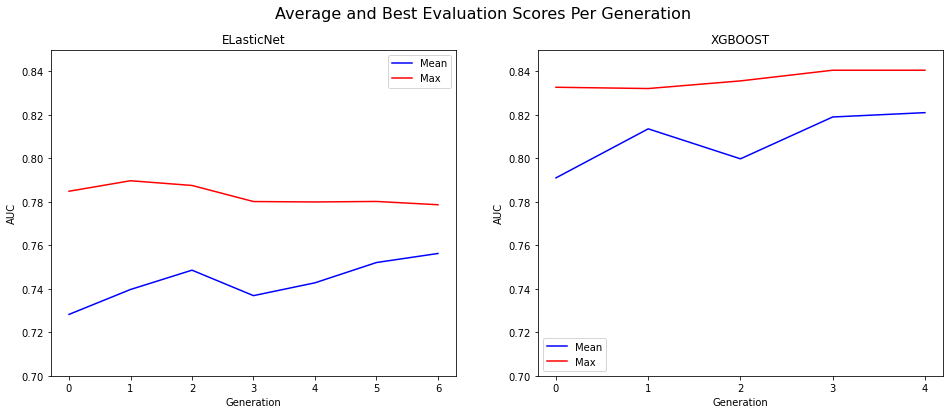

In [18]:
# Summarise EN scores
df_temp_EN = df_ENet_AUC.groupby('generation')['evaluation_score'].agg(['mean', 'max']).reset_index()
df_temp_EN['model'] = 'ElasticNet'

# Summarise XG scores
df_temp_XG = df_xgb_AUC.groupby('generation')['evaluation_score'].agg(['mean', 'max']).reset_index()
df_temp_XG['model'] = 'XGBOOST'

# Combine Dataframes
df_vis = pd.concat([df_temp_EN, df_temp_XG])

# Plot evaluation score
fig, ax = plt.subplots(1, 2, figsize=(16,6))
fig.suptitle("Average and Best Evaluation Scores Per Generation", fontsize=16)    
ax[0].set_title("ELasticNet")
ax[1].set_title("XGBOOST")
sns.lineplot(data = df_temp_EN, x= 'generation', y='mean', color="blue", label='Mean', ax = ax[0])
sns.lineplot(data = df_temp_EN, x= 'generation', y='max', color="red", label='Max', ax = ax[0])
sns.lineplot(data = df_temp_XG, x= 'generation', y='mean', color="blue", label='Mean', ax = ax[1])
sns.lineplot(data = df_temp_XG, x= 'generation', y='max', color="red", label='Max', ax = ax[1])
ax[0].set(ylim=(0.7, 0.85))
ax[1].set(ylim=(0.7, 0.85))
ax[0].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[1].xaxis.set_major_locator(MaxNLocator(integer=True))
plt.setp(ax[:], xlabel='Generation')
plt.setp(ax[:], ylabel='AUC')
plt.show()

# Clear objects
del df_temp_EN, df_temp_XG, fig, df_vis, ax

Above we can see that the mean scores are increasing, the distribution of features are becoming much tighter as the model converges towards popular predictors.

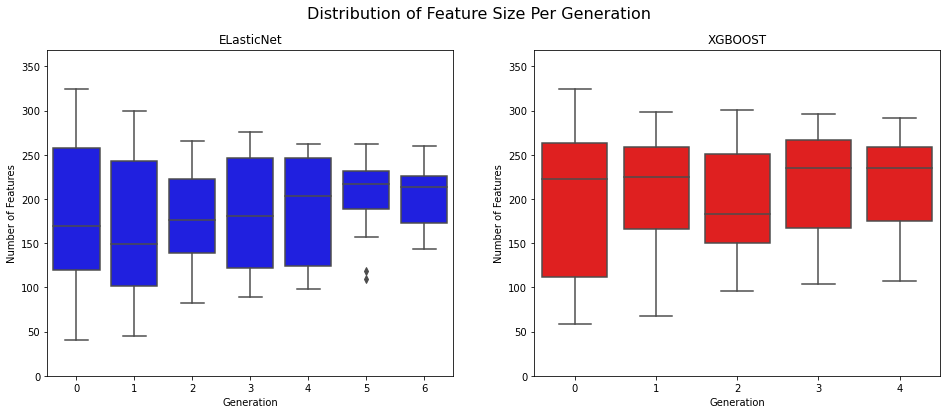

In [19]:
# EN scores
df_temp_EN = df_ENet_AUC

# XG scores
df_temp_XG = df_xgb_AUC

# Plot evaluation score
fig, ax = plt.subplots(1, 2, figsize=(16,6))
fig.suptitle("Distribution of Feature Size Per Generation", fontsize=16)    
ax[0].set_title("ELasticNet")
ax[1].set_title("XGBOOST")
sns.boxplot(data = df_temp_EN, x= 'generation', y='feature_size', color="blue", ax = ax[0])
sns.boxplot(data = df_temp_XG, x= 'generation', y='feature_size', color="red", ax = ax[1])
ax[0].set(ylim=(0, 369))
ax[1].set(ylim=(0, 369))
plt.setp(ax[:], xlabel='Generation')
plt.setp(ax[:], ylabel='Number of Features')
plt.show()

# Clear objects
del df_temp_EN, df_temp_XG, fig, ax

The chart below shows the average similarity within the population against the best solution found in a generation. Similarity is in reference to the features included in the model using JACCARD similarity.

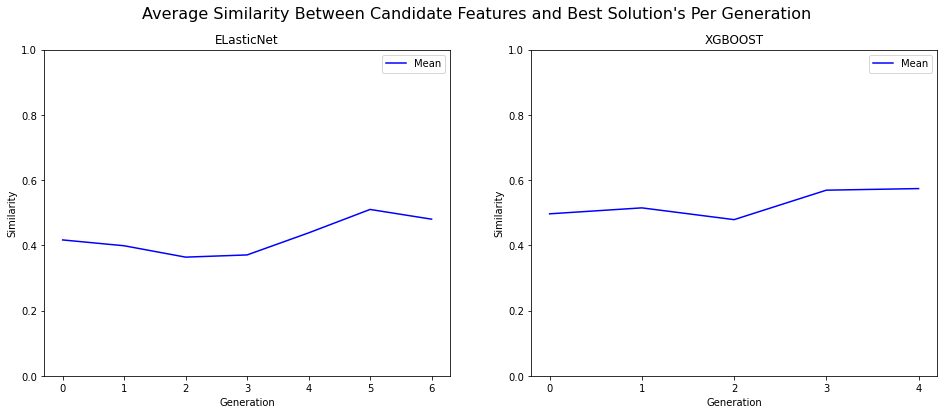

In [20]:
# Summarise EN scores
df_temp_EN = df_ENet_AUC.groupby('generation')['similarity_features'].agg(['mean']).reset_index()
df_temp_EN['model'] = 'ElasticNet'

# Summarise XG scores
df_temp_XG = df_xgb_AUC.groupby('generation')['similarity_features'].agg(['mean', 'max']).reset_index()
df_temp_XG['model'] = 'XGBOOST'

# Combine Dataframes
df_vis = pd.concat([df_temp_EN, df_temp_XG])

# Plot evaluation score
fig, ax = plt.subplots(1, 2, figsize=(16,6))
fig.suptitle("Average Similarity Between Candidate Features and Best Solution's Per Generation", fontsize=16)    
ax[0].set_title("ELasticNet")
ax[1].set_title("XGBOOST")
sns.lineplot(data = df_temp_EN, x= 'generation', y='mean', color="blue", label='Mean', ax = ax[0])
sns.lineplot(data = df_temp_XG, x= 'generation', y='mean', color="blue", label='Mean', ax = ax[1])
ax[0].set(ylim=(0, 1))
ax[1].set(ylim=(0, 1))
ax[0].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[1].xaxis.set_major_locator(MaxNLocator(integer=True))
plt.setp(ax[:], xlabel='Generation')
plt.setp(ax[:], ylabel='Similarity')
plt.show()

# Clear objects
del df_temp_EN, df_temp_XG, fig, df_vis, ax

We can see that the hyperparameters conver much faster, likely due to the smaller range of values to start with.

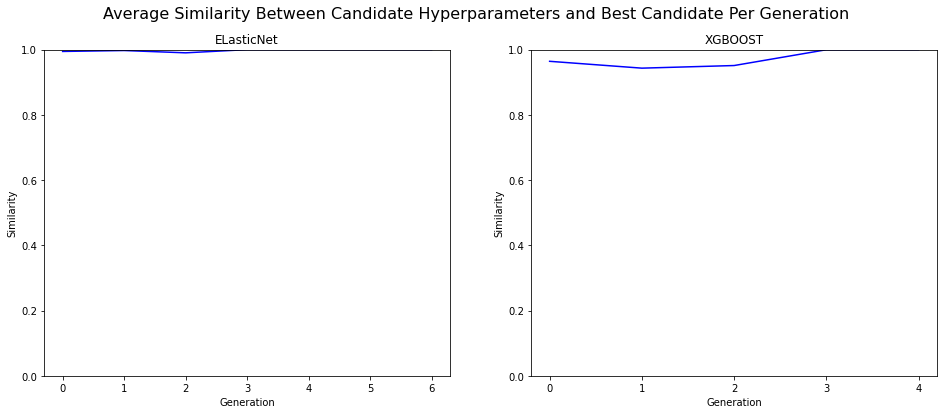

In [21]:
# Summarise EN scores
df_temp_EN = df_ENet_AUC.groupby('generation')['similarity_hyperparameters'].agg(['mean']).reset_index()
df_temp_EN['model'] = 'ElasticNet'

# Summarise XG scores
df_temp_XG = df_xgb_AUC.groupby('generation')['similarity_hyperparameters'].agg(['mean', 'max']).reset_index()
df_temp_XG['model'] = 'XGBOOST'

# Combine Dataframes
df_vis = pd.concat([df_temp_EN, df_temp_XG])

# Plot evaluation score
fig, ax = plt.subplots(1, 2, figsize=(16,6))
fig.suptitle("Average Similarity Between Candidate Hyperparameters and Best Candidate Per Generation", fontsize=16)    
ax[0].set_title("ELasticNet")
ax[1].set_title("XGBOOST")
sns.lineplot(data = df_temp_EN, x= 'generation', y='mean', color="blue", ax = ax[0])
sns.lineplot(data = df_temp_XG, x= 'generation', y='mean', color="blue", ax = ax[1])
ax[0].set(ylim=(0, 1))
ax[1].set(ylim=(0, 1))
ax[0].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[1].xaxis.set_major_locator(MaxNLocator(integer=True))
plt.setp(ax[:], xlabel='Generation')
plt.setp(ax[:], ylabel='Similarity')
plt.show()

# Clear objects
del df_temp_EN, df_temp_XG, fig, df_vis, ax

<a id="section-eight"></a>
## Model Evaluation

We can now use the best model found by the GA and use this to predict against our validation dataset, the output below shows how the model performs on the training set in CV and the validation set.

In [22]:
#################################################################################################################
# -------------------------------------------------- ElasticNet -------------------------------------------------
#################################################################################################################

# Extract best solution
df_best_en = df_ENet_AUC[df_ENet_AUC.fitness_score == max(df_ENet_AUC.fitness_score)]

# Extract features
l_best_features_en = (df_best_en.features.tolist())[0]

# Extract the hyperparameters
l_best_hyperparms_en = (df_best_en.hyperparameters.tolist())[0]
n_hyperparams_en = len(l_best_hyperparms_en['name'])
hyperparameters_en = {l_best_hyperparms_en['name'][0]:l_best_hyperparms_en['value'][0]}
if n_hyperparams_en > 1:
    for i in range(n_hyperparams_en):
        tempparameters = {l_best_hyperparms_en['name'][i]:l_best_hyperparms_en['value'][i]}
        hyperparameters_en = {**hyperparameters_en, **tempparameters}

# Create model object
model_en = ElasticNet()

# Set Hyperparameters
model_en.set_params(**hyperparameters_en)

# Fit model
model_en.fit(df_train.iloc[:,l_best_features_en], df_train.TARGET)

# Predict on validation
y_pred_en = model_en.predict(df_validation.iloc[:,l_best_features_en])


#################################################################################################################
# --------------------------------------------------- XGBOOST ---------------------------------------------------
#################################################################################################################

# Extract best solution
df_best_xg = df_xgb_AUC[df_xgb_AUC.fitness_score == max(df_xgb_AUC.fitness_score)]

# Extract features
l_best_features_xg = (df_best_xg.features.tolist())[0]

# Extract the hyperparameters
l_best_hyperparms_xg = (df_best_xg.hyperparameters.tolist())[0]
n_hyperparams_xg = len(l_best_hyperparms_xg['name'])
hyperparameters_xg = {l_best_hyperparms_xg['name'][0]:l_best_hyperparms_xg['value'][0]}
if n_hyperparams_xg > 1:
    for i in range(n_hyperparams_xg):
        tempparameters = {l_best_hyperparms_xg['name'][i]:l_best_hyperparms_xg['value'][i]}
        hyperparameters_xg = {**hyperparameters_xg, **tempparameters}

# Create model object
model_xg = XGBClassifier(scale_pos_weight = 25)

# Set Hyperparameters
model_xg.set_params(**hyperparameters_xg)

# Fit model
model_xg.fit(df_train.iloc[:,l_best_features_xg], df_train.TARGET)

# Predict on validation
y_pred_temp = ((model_xg.predict_proba(df_validation.iloc[:,l_best_features_xg])).tolist())
y_pred_xg = []
for i in range(len(df_validation)):
    y_pred_xg.append(y_pred_temp[i][1])

In [23]:
#################################################################################################################
# ------------------------------------------------ Output Scores ------------------------------------------------
#################################################################################################################

# Evaluation scores
print('ElasticNET')
print('Train Set AUC:', round((df_best_en.evaluation_score.tolist())[0], 3))
print('Validation Set AUC:', round(metrics.roc_auc_score(df_validation.TARGET, y_pred_en), 3))
print(' ')

# Evaluation scores
print('XGBOOST')
print('Train Set AUC:', round((df_best_xg.evaluation_score.tolist())[0], 3))
print('Validation Set AUC:', round(metrics.roc_auc_score(df_validation.TARGET, y_pred_xg), 3))

ElasticNET
Train Set AUC: 0.79
Validation Set AUC: 0.762
 
XGBOOST
Train Set AUC: 0.841
Validation Set AUC: 0.813


<a id="section-nine"></a>
## Conclusion

To conclude, GA appears to be a useful tool to apply both feature selection and hyperparameter tuning. The main drawback found during this process is the computational commitment required, while my code can 100% be optimised it is a relatively significant time committment. Taking the execution point out of consideration for the moment the GA does typically drive the modelling solution in the right areas of the search space.

In practice I might be more tempted to use GA to generate sparse models with reasonable predictive power rather than to maximise a performance metric. I might explore this in another notebook.

It has been good practice playing with functions and creating a workflow for both machine learning models and for a hack implementation of a GA for hyperparameter tuning and feature selection.

<a id="section-ten"></a>
## Submission

In [24]:
# Read and submit score
y_pred_temp = ((model_xg.predict_proba(df_test.iloc[:,l_best_features_xg])).tolist())
y_pred = []
for i in range(len(df_test)):
    y_pred.append(y_pred_temp[i][1])
submission = pd.read_csv('../input/santander-customer-satisfaction/sample_submission.csv', encoding='latin-1')
submission.loc[:, 'TARGET'] = y_pred
submission.to_csv('submission.csv', index=False)

<a id="section-eight"></a>
